## Offensive Language Identification

This is the task 'a' in Task 6: OffensEval: Identifying and Categorizing Offensive Language in Social Media in SemEval 2019. We have explored how a pooled GRU can be used in Offensive language identification. 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
from unidecode import unidecode

Using TensorFlow backend.


Get reproducable results

In [2]:
from numpy.random import seed
from tensorflow import set_random_seed

seed(726)
set_random_seed(726)

### Loading the training and testing files

In [3]:
train = pd.read_csv("Data/training/offenseval-training-v1.tsv", sep='\t')

test_tweets = pd.read_csv("Data/testing/testset-taska.tsv", sep='\t')
test_labels = pd.read_csv("Data/testing/labels-test-a.csv", header=-1, names = ["id", "subtask_a"])

test = pd.merge(test_tweets, test_labels, on=['id','id'])
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (13240, 5)
Test shape :  (860, 3)


Changing case of the tweets to lower case, since the embedding model only has lower case words

In [4]:
train["tweet"] = train["tweet"].str.lower()
test["tweet"] = test["tweet"].str.lower()

cleaning the puncutation marks

In [5]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train["tweet"] = train["tweet"].apply(lambda x: clean_text(x))
test["tweet"] = test["tweet"].apply(lambda x: clean_text(x))

In [6]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = 72 # max number of words in a question to use #99.99%

## fill up the missing values
X = train["tweet"].fillna("_na_").values
X_test = test["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

## Get the target values
Y = train['subtask_a'].values
Y

array(['OFF', 'OFF', 'NOT', ..., 'OFF', 'OFF', 'NOT'], dtype=object)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(Y)
encoded_Y = le.transform(Y)
encoded_Y

array([1, 1, 0, ..., 1, 1, 0])

Building the Embedding matrix

In [8]:
word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    EMBEDDING_FILE = '/data/glove/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '/data/fasttext/crawl-300d-2M-subword.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

Only Glove vectors have been used in embedding matrix. Can explore it further in future

In [9]:
embedding_matrix = load_glove(word_index)

In [13]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [14]:
def f1_smart(y_true, y_pred):
    args = np.argsort(y_pred)
    tp = y_true.sum()
    fs = (tp - np.cumsum(y_true[args[:-1]])) / np.arange(y_true.shape[0] + tp - 1, tp, -1)
    res_idx = np.argmax(fs)
    return 2 * fs[res_idx], (y_pred[args[res_idx]] + y_pred[args[res_idx + 1]]) / 2

Training with early stopping and reducing learning rate on plateu. In each fold values for the test set is also predicted, And after the process, predicted values for the test file would be mean from each fold

In [15]:
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
bestscore = []
y_test = np.zeros((X_test.shape[0], ))
for i, (train_index, valid_index) in enumerate(kfold.split(X, encoded_Y)):
    X_train, X_val, Y_train, Y_val = X[train_index], X[valid_index], encoded_Y[train_index], encoded_Y[valid_index]
    filepath="Models/cnn_weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    model = get_model()
    if i == 0:print(model.summary()) 
    model.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks, 
             )
    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=64, verbose=2)
    y_test += np.squeeze(model.predict([X_test], batch_size=64, verbose=2))/5
    f1, threshold = f1_smart(np.squeeze(Y_val), np.squeeze(y_pred))
    print('Optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
    bestscore.append(threshold)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 72, 300)      6036600     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 72, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 72, 160)      182880      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
global_ave


Epoch 00012: val_loss did not improve from 0.45308
Epoch 13/20
 - 17s - loss: 0.0881 - acc: 0.9691 - val_loss: 0.8442 - val_acc: 0.7466

Epoch 00013: val_loss did not improve from 0.45308
Epoch 14/20
 - 17s - loss: 0.0840 - acc: 0.9705 - val_loss: 0.8691 - val_acc: 0.7406

Epoch 00014: val_loss did not improve from 0.45308
Epoch 15/20
 - 16s - loss: 0.0790 - acc: 0.9721 - val_loss: 0.8955 - val_acc: 0.7436

Epoch 00015: val_loss did not improve from 0.45308
Epoch 16/20
 - 17s - loss: 0.0776 - acc: 0.9728 - val_loss: 0.9273 - val_acc: 0.7413

Epoch 00016: val_loss did not improve from 0.45308
Epoch 17/20
 - 16s - loss: 0.0770 - acc: 0.9727 - val_loss: 0.9213 - val_acc: 0.7372

Epoch 00017: val_loss did not improve from 0.45308
Epoch 18/20
 - 17s - loss: 0.0719 - acc: 0.9754 - val_loss: 0.9571 - val_acc: 0.7383

Epoch 00018: val_loss did not improve from 0.45308
Epoch 19/20
 - 16s - loss: 0.0693 - acc: 0.9759 - val_loss: 0.9650 - val_acc: 0.7353

Epoch 00019: val_loss did not improve fr

 - 16s - loss: 0.3567 - acc: 0.8404 - val_loss: 0.4571 - val_acc: 0.7976

Epoch 00003: val_loss did not improve from 0.43954

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 4/20
 - 16s - loss: 0.2736 - acc: 0.8830 - val_loss: 0.5067 - val_acc: 0.7851

Epoch 00004: val_loss did not improve from 0.43954

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 5/20
 - 16s - loss: 0.2120 - acc: 0.9157 - val_loss: 0.5550 - val_acc: 0.7806

Epoch 00005: val_loss did not improve from 0.43954

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.
Epoch 6/20
 - 16s - loss: 0.1738 - acc: 0.9335 - val_loss: 0.6169 - val_acc: 0.7719

Epoch 00006: val_loss did not improve from 0.43954

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00012960000021848827.
Epoch 7/20
 - 16s - loss: 0.1537 - acc: 0.9433 - val_loss: 0.6274 - val_acc: 0.7768

Epoch 00007: val_loss did not improve from 0.43954

Epoc

Converting the predictions for integer.

In [16]:
y_test = y_test.reshape((-1, 1))
pred_test_y = (y_test>np.mean(bestscore)).astype(int)
test['predictions'] = le.inverse_transform(pred_test_y)

/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test["subtask_a"], test['predictions']).ravel()
(tn, fp, fn, tp)

(535, 85, 61, 179)

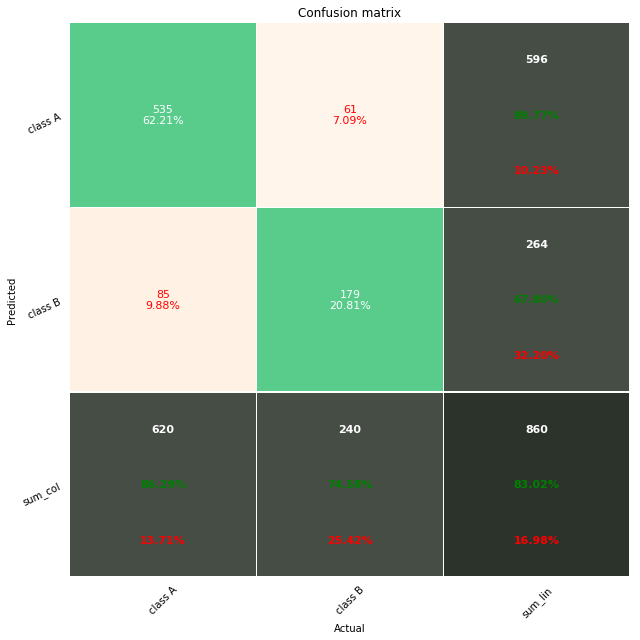

In [19]:
from visualization.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

columns = []
annot = True
cmap = 'Oranges'
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
# size::
fz = 12;
figsize = [9, 9];
if len(y_test) > 10:
    fz = 9;
    figsize = [14, 14];
plot_confusion_matrix_from_data(test["subtask_a"], test['predictions'], columns,
                                    annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

### Accuracy

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(test["subtask_a"], test['predictions'])

0.8302325581395349